Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [43]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### NOTES : 
- Used google drive for images, make sure to update path accordingly. 
- Make sure augmented output folders are deleted before

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [45]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Test')

In [46]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [47]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [48]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [49]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [50]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


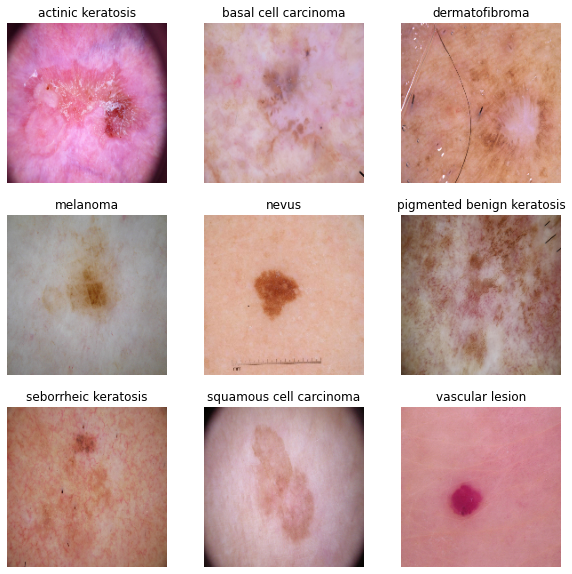

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  for images, labels in train_ds.take(50):
    if(labels[i] == i):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [53]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.091503315 0.8539226


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [54]:
### Todo, choose an appropirate optimiser and loss function
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [56]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 85ms/step - loss: 2.0912 - accuracy: 0.2969 - val_loss: 1.7507 - val_accuracy: 0.3758
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6319 - accuracy: 0.4118 - val_loss: 1.5753 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4189 - accuracy: 0.4961 - val_loss: 1.4410 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3419 - accuracy: 0.5446 - val_loss: 1.4444 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2478 - accuracy: 0.5614 - val_loss: 1.3235 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2068 - accuracy: 0.5714 - val_loss: 1.4761 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1215 - accuracy: 0.5999 - val_loss: 1.3508 - val_accuracy: 0.5369
Epoch 8/20
56

### Visualizing training results

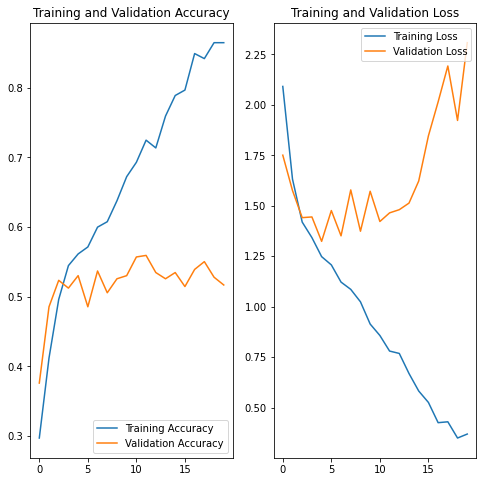

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### OBSERVATIONS : The model appears to be overfitting since training accuracy is very high and the validation accuracy is low.

#### Since these are images of skin, actual images are possible to be taken from different direction hence horizontal and vertial flip is applied


In [58]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

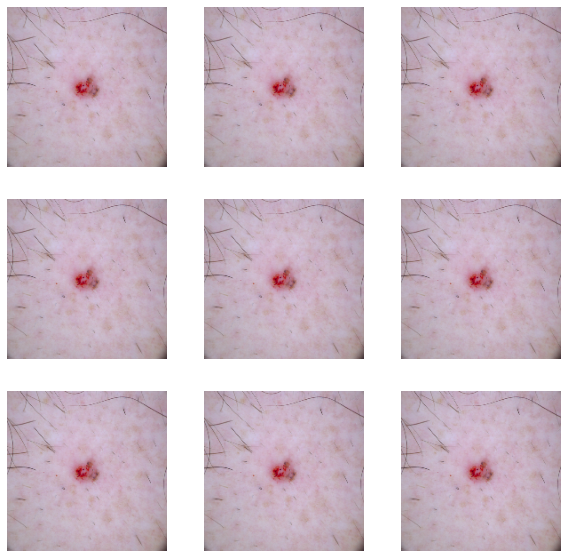

In [59]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [60]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



### Compiling the model

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [62]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 29ms/step - loss: 1.9800 - accuracy: 0.2790 - val_loss: 1.7866 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 1s 27ms/step - loss: 1.6232 - accuracy: 0.4124 - val_loss: 1.5073 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4915 - accuracy: 0.4732 - val_loss: 1.6154 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4310 - accuracy: 0.4989 - val_loss: 1.4200 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4168 - accuracy: 0.5045 - val_loss: 1.4904 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 1s 27ms/step - loss: 1.3826 - accuracy: 0.5145 - val_loss: 1.5697 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3625 - accuracy: 0.5117 - val_loss: 1.3779 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

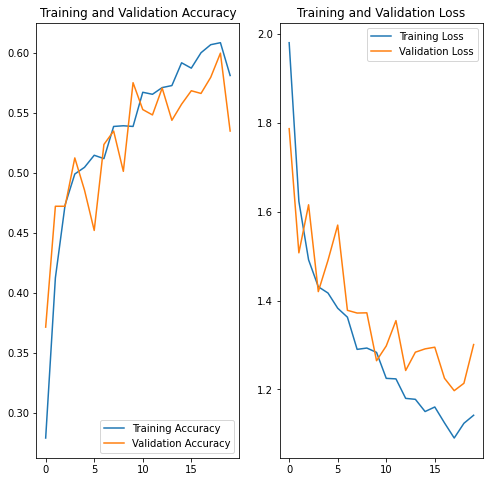

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations : There has been some improvement with regards to the overfitting of the model. However the overall accuracy is still bit low.

#### Checking Class Distribution

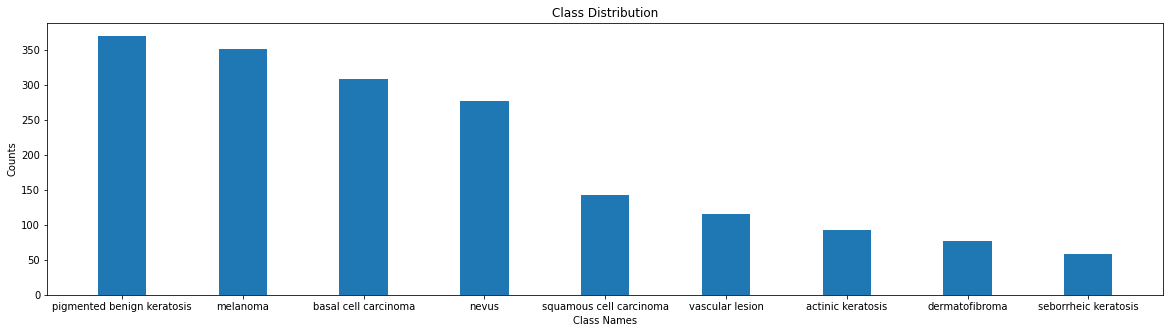

In [64]:
labels = []
for x, y in train_ds:
  labels.append(y.numpy())
labels = np.concatenate(labels, axis = 0)
train_df = pd.DataFrame(labels)
train_df.columns = ['Index']
train_df['Label'] = train_df['Index'].apply(lambda x: class_names[x])
freq = train_df['Label'].value_counts()

fig = plt.figure(figsize = (20, 5))
 
plt.bar(freq.index, freq.values, width = 0.4)
 
plt.xlabel("Class Names")
plt.ylabel("Counts")
plt.title("Class Distribution")
plt.show()

#### Observations: 
#### - Which class has the least number of samples? - pigmented benign keratosis
#### - Which classes dominate the data in terms proportionate number of samples? - seborrheic keratosis


#### To rectify the class imbalance we will use Augmentor to add more sample to the training set.
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [65]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [66]:
path_to_training_dataset= str(data_dir_train) + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14E11EB550>: 100%|██████████| 500/500 [00:20<00:00, 24.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14E7356ED0>: 100%|██████████| 500/500 [00:21<00:00, 22.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14E1B942D0>: 100%|██████████| 500/500 [00:22<00:00, 22.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F14E72EE990>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F1579CD8B50>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F14E41AA250>: 100%|██████████| 500/500 [00:19<00:00, 25.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1577D57ED0>: 100%|██████████| 500/500 [00:43<00:00, 11.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14E19C6690>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14E1C86A50>: 100%|██████████| 500/500 [00:18<00:00, 26.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [67]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [68]:
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
path_list

[PosixPath('/content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_c57cb003-860d-4777-9c27-ef7cfcf8eee5.jpg'),
 PosixPath('/content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_5202c513-42ee-4876-b5b7-f80722c556fa.jpg'),
 PosixPath('/content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_1e7e9d6f-9ccb-4bc7-91e7-1654ac8aaa7c.jpg'),
 PosixPath('/content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_8ce33dbb-fe9d-49ea-99a0-7fcb2dea6ea6.jpg'),
 PosixPath('/content/gdrive/My Drive/Upgrad/CNN_assignment/ISIC Skin Cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_78c84153-4c4b-4173-ad60-43f0eb419742.jpg'),
 PosixPath('/content/gdri

In [69]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [70]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [71]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [72]:
df2['Label'].value_counts()

actinic keratosis             500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
dermatofibroma                500
vascular lesion               500
basal cell carcinoma          500
melanoma                      500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [73]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [74]:
#data_dir_train=data_dir_train
## Keeping the directory path same as earlier, as keras reads all the images from subfolders as well
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [75]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [76]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [77]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.018649165 0.78837025


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [78]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [79]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [80]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [81]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 11s 61ms/step - loss: 1.9467 - accuracy: 0.2684 - val_loss: 1.5300 - val_accuracy: 0.4246
Epoch 2/30
169/169 [==============================] - 5s 29ms/step - loss: 1.5299 - accuracy: 0.4186 - val_loss: 1.4265 - val_accuracy: 0.4284
Epoch 3/30
169/169 [==============================] - 4s 26ms/step - loss: 1.3884 - accuracy: 0.4651 - val_loss: 1.3174 - val_accuracy: 0.4907
Epoch 4/30
169/169 [==============================] - 4s 26ms/step - loss: 1.3366 - accuracy: 0.4800 - val_loss: 1.3049 - val_accuracy: 0.5033
Epoch 5/30
169/169 [==============================] - 4s 26ms/step - loss: 1.3309 - accuracy: 0.4902 - val_loss: 1.3679 - val_accuracy: 0.4855
Epoch 6/30
169/169 [==============================] - 4s 26ms/step - loss: 1.2709 - accuracy: 0.5141 - val_loss: 1.2112 - val_accuracy: 0.5457
Epoch 7/30
169/169 [==============================] - 5s 27ms/step - loss: 1.2042 - accuracy: 0.5341 - val_loss: 1.2147 - val_accuracy: 0.537

#### **Todo:**  Visualize the model results

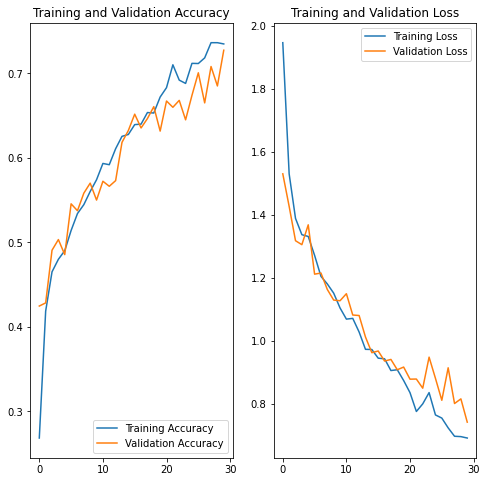

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations : There has been significant improvement in the overall model performace after the augmentation. Overall accuracy is improved.

- Number of images in training data affects accuracy
- Augmentation also needed to make sure model trains correctly on variations
- Increase in epochs also increases the chances of accuracy